In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [601]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D


from astropy.coordinates import (cartesian_to_spherical, SkyCoord, Distance, Galactic, EarthLocation, AltAz, CartesianRepresentation, SphericalRepresentation)
from astropy import units as u
# Calculate observer's local sidereal time (LST)
from astropy.time import Time
from astropy.coordinates import EarthLocation
from scipy.special import erf

import sys
sys.path.append('/content/drive/MyDrive/LE2023/code')

import var_constants as vc
import dust_constants as dc
import fix_constants as fc


plt.style.use('seaborn-v0_8-colorblind')

%config InlineBackend.figure_format='retina'

In [602]:
# pull out available wavelengths for Qsc values, convert to cm from um, and take the log
path_dustdata = '/content/drive/MyDrive/LE2023/dust/data/'

In [603]:
# older models used for g (degree of forward scattering) values
# carbonaceous dust
carbong = path_dustdata+'dustmodels_WD01/Gra_81.dat'
gcarb = np.loadtxt(carbong, usecols=(3), unpack=True)
# silicate dust
silicong = path_dustdata+'dustmodels_WD01/suvSil_81.dat'
gsil = np.loadtxt(silicong, usecols=(3), unpack=True)

In [604]:
len(gcarb)

19521

In [605]:
# curvature function
def F(a, beta, at):
    """
    Calculates the curvature term (Eq. 6) from Weingartner & Draine (2001)


    Inputs:
    -----
    a: float
    Value of the grain size in cm

    beta: float
    Constant, taken from Table 1 of Weingartner & Draine (2001)

    at: float
    Value of the upper limit for size, in cm


    Outputs:
    -----
    1 + (beta * a / at): float
    Value of F if beta is greater than or equal to zero

    (1 - (beta * a / at))^-1: float
    Value of F if beta is less than 0
    """

    # determine if value of beta is > or = 0
    if beta >= 0:
        # return value of first form
        return 1 + (beta * a / at)
    # if beta < 0
    else:
        # return value of second form
        return (1 - (beta * a / at))**(-1)


In [606]:
# D(a), size distribution for the smallest grains
def Da_carb(a, B1, B2):
    """
    Calculates the value of D(a) (Eq. 2) from Weingartner & Draine (2001)


    Inputs:
    -----
    a: float
    Value of the grain size in cm

    B1: float
    Result from Bi_carb(a01, bc1)

    B2: float
    Result from Bi_carb(a02, bc2)


    Outputs:
    -----
    da1+da2: float
    Addition of the two terms from the summation
    """

    # expression for i=1
    da1 = (B1/a)*np.exp(-0.5*(np.log(a/dc.a01)/dc.sig)**2)
    # expression for i=2
    da2 = (B2/a)*np.exp(-0.5*(np.log(a/dc.a02)/dc.sig)**2)
    # sum da1+da2 and return
    return da1+da2

In [607]:
# including very small grains for carbonaceous dust
# Bi for B1 and B2 to go into D(a)
def Bi_carb(a0i,bci):
    """
    Calculates the value of Bi (Eq. 3) from Weingartner & Draine (2001)


    Inputs:
    -----
    a0i: float
    Value of the minimum grain size in cm, a01 or a02

    bci: float
    Value of the total C abundance per H nucleus, bc1 or bc2

    NOTE: a normalization factor (sig), the density of graphite (rho), and the mass of a carbon atom (mc) are set in a separate file, dustconst.py.


    Outputs:
    -----
    Bi1*Bi2: float
    Product of the two terms for Bi, unitless
    """

    # calculate the first term of Bi
    Bi1 = ((3 / (2*np.pi)**(3/2)) * np.exp(-4.5*dc.sig**2) / (dc.rho*a0i**3*dc.sig))
    # calculate the second term of Bi
    Bi2 = bci*dc.mc / (1 + erf((3*dc.sig/np.sqrt(2)) + (np.log(a0i/dc.a01)/(dc.sig*np.sqrt(2)))))
    # multiply the two terms and return
    return Bi1*Bi2

In [608]:
# distribution for carbonaceous dust given grain size
def Dist_carb(a, B1, B2):
    """
    Calculates the grain size distribution for carbonaceous "graphite" grains (Eq. 4) from Weingartner & Draine (2001)


    Inputs:
    -----
    a: float
    Value of the grain size in cm

    B1: float
    Result from Bi_carb(a01, bc1)

    B2: float
    Result from Bi_carb(a02, bc2)

    NOTE: constants Cg, alphag, betag, cutoff grain size (atg), and control size (acg) are set in separate file dustconst.py.


    Outputs:
    -----
    Number of grains for a particular size (units 1/cm)
    """

    # (4) = D(a) + dist1 * [1 or dist2]
    # calculate the first term, dist1
    dist1 = ((dc.Cg/a)*(a/dc.atg)**dc.alphag * F(a, dc.betag, dc.atg))

    # determine which additional term to use based on grain size
    # if a < 3.5e-8, the function is undefined so return 0
    if a.value < 3.5e-8:
        return 0
    # if 3.5e-8 <= a < atg, return the result of Da_carb(a, B1, B2) + dist1 * 1
    elif a.value >= 3.5e-8 and a < dc.atg:
        return Da_carb(a, B1, B2) + dist1
    # if a > atg, return the result of Da_carb(a, B1, B2) + (dist1*dist2)
    else:
        dist2 = np.exp(-((a - dc.atg)/dc.acg)**3)
        return Da_carb(a, B1, B2) + (dist1 * dist2)




In [609]:
# create array of sizes used only for plotting distributions
a = np.linspace(3.5e-8, 1.0e-4, 10000)*u.cm

In [610]:
# grain size distribution for carbonaceous dust
# calculate B1
B1 = Bi_carb(dc.a01, dc.bc1)
# calculate B2
B2 = Bi_carb(dc.a02, dc.bc2)
carbon_distribution = [Dist_carb(idx, B1, B2).value for idx in a]/u.cm

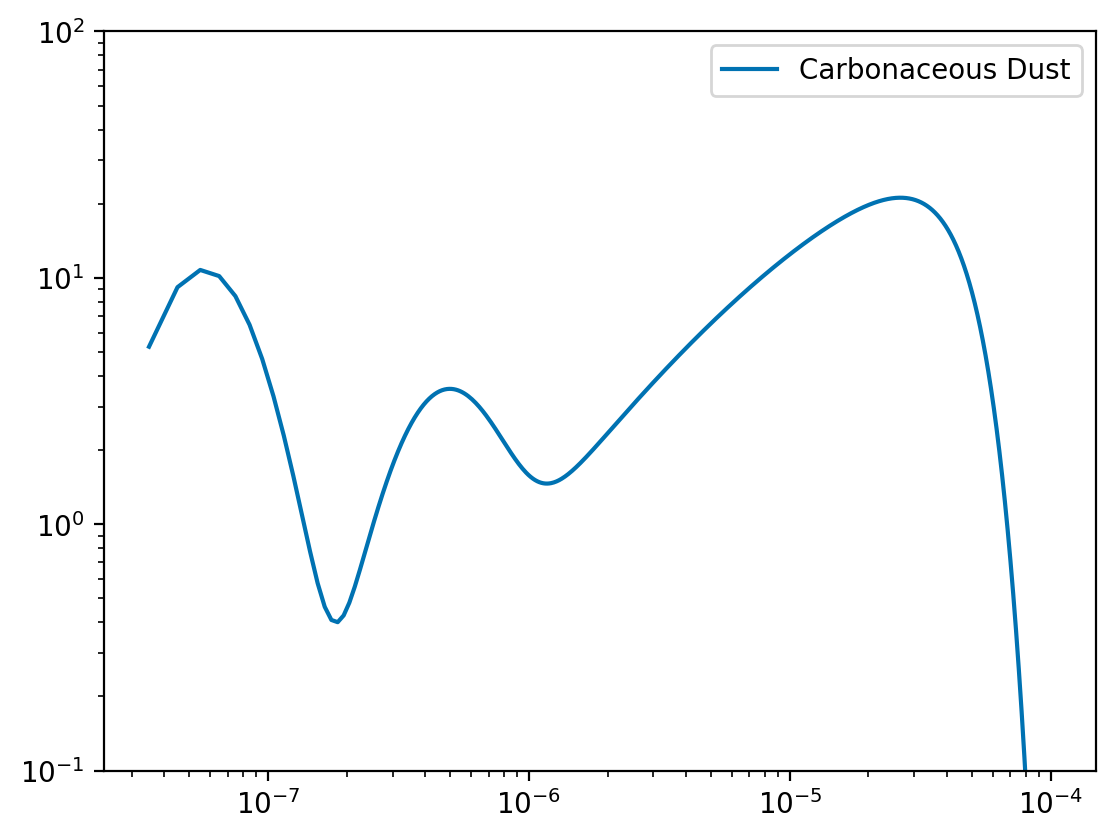

In [611]:
plt.figure()

plt.loglog(a, 1e29*a**4*carbon_distribution, label='Carbonaceous Dust')
plt.ylim(0.1, 100)
plt.legend(ncol=1, loc='best')
plt.show()


In [612]:
r0 = vc.r0ly
ct = vc.ct

x_p = np.linspace(-10,10,100)
y_p = np.linspace(-10,10,100)

x_p, y_p = np.meshgrid(x_p, y_p)
z_p = (x_p**2 + y_p**2 - ct**2) / (2 * ct)
z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]

# Define the radius and center of the sphere
h = x_p[43, 70]
k = y_p[43, 70]
l = z_p[43, 70]
center = (h, k, l)

# Find points of intersection
intersection_points = []

for i in range(100):
  for j in range(100):
    x_par, y_par, z_par = x_p[i,j], y_p[i,j], z_p[i,j]

    # Check if the point is inside both the sphere and the paraboloid
    sphere_condition = ((x_par - center[0])**2 + (y_par - center[1])**2 + (z_par - center[2])**2) <= r0**2
    paraboloid_condition = (x_par**2 + y_par**2) <= (ct**2 + 2 * ct * z_par)

    if (sphere_condition and paraboloid_condition):
        intersection_points.append((x_par, y_par, z_par))

x_inter = np.array([inter[0] for inter in intersection_points])
y_inter = np.array([inter[1] for inter in intersection_points])
z_inter = np.array([inter[2] for inter in intersection_points])

<ipython-input-612-739844770562>:9: RuntimeWarning: invalid value encountered in sqrt
  z_e = np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]
<ipython-input-612-739844770562>:10: RuntimeWarning: invalid value encountered in sqrt
  z_e2 = -np.sqrt(r0**2 - (x_p-x_p[43, 70])**2 - (y_p-y_p[43, 70])**2) + z_p[43, 70]


In [613]:
#----------
# Calculate integrated scattering function
#----------

# Eq. (8) from Sugerman (2003)

# calculate radius (r from Fig. 1, Sugerman 2003) for echo in given observation
# rad = np.sqrt(c.pecho**2 + c.z**2) #ly
rad = np.sqrt(x_inter**2 + y_inter**2 + z_inter**2)
ll = np.sqrt(x_inter**2 + y_inter**2 + (z_inter-vc.d)**2)

mu = (x_inter**2 + y_inter**2 + z_inter*(z_inter - vc.d)) / (rad * ll)


In [614]:
fc.pctoly * fc.pctom

1.006517416e+17

In [615]:
# extract Qsc(lambda, a) value from table
def extract_Qsc_g(wave, a, sizeg, waveg, valuesq):
    """
    Extracts and returns the value of Qsc from interpolated data table from Draine et al. (2021); ApJ 917,3. Qsc describes the grain scattering efficiency.


    Inputs:
    -----
    wave: float
    A specified value for the wavelength in cm, on which Qsc depends

    a: float
    A specified value for the size of the grain in cm, on which Qsc depends

    pointsq: array-like
    An array of (wavelength, size) points

    valuesq: array-like
    An array of Qsc values corresponding to each (wavelength, size) point


    Outputs:
    -----
    valuesq[idx]: float
    The corresponding value of Qsc for the specified (wave, a) point
    """

    # a = 1.259E-03
    # w = 6.310E+02
    # iterate over the array of points to search for matching (wave, a) point
    for idx in range(0,len(sizeg)):
      for idy in range(0,len(waveg)):
        # if the first value of the current point matches wave and if the second value matches a
        # return the corresponding Qsc value
        if sizeg[idx] == a and waveg[idy] == wave:
          ids = len(waveg) * idx + idy
          return valuesq[ids]
        # if one or both do not match, move to the next iteration
        else:
          continue

In [616]:
# pull out available wavelengths for g values, convert to cm from um, and take the
waveg = np.loadtxt(path_dustdata+'dustmodels_WD01/LD93_wave.dat', unpack=True) #micronm
# pull out available sizes for the g values, convert to cm from um, and take the log
sizeg = np.loadtxt(path_dustdata+'dustmodels_WD01/LD93_aeff.dat', unpack=True) #micron

# older models used for g (degree of forward scattering) values
# carbonaceous dust
carbonQ = path_dustdata+'dustmodels_WD01/Gra_81.dat'
Qcarb = np.loadtxt(carbong, usecols=(2), unpack=True)
# silicate dust
siliconQ = path_dustdata+'dustmodels_WD01/suvSil_81.dat'
Qsil = np.loadtxt(silicong, usecols=(2), unpack=True)

# older models used for g (degree of forward scattering) values
# carbonaceous dust
carbong = path_dustdata+'dustmodels_WD01/Gra_81.dat'
gcarb = np.loadtxt(carbong, usecols=(3), unpack=True)
# silicate dust
silicong = path_dustdata+'dustmodels_WD01/suvSil_81.dat'
gsil = np.loadtxt(silicong, usecols=(3), unpack=True)

In [617]:
len(Qcarb), len(waveg), len(sizeg)

(19521, 241, 81)

In [618]:
extract_Qsc_g(wave = 6.310E+02, a = 1.259E-03, sizeg=sizeg, waveg=waveg, valuesq=Qcarb)

6.544e-20

In [619]:
extract_Qsc_g(wave = 1.000E-03 , a = 1.122E-03, sizeg=sizeg, waveg=waveg, valuesq=gcarb)

0.949

In [620]:
# calculate the phase function Phi(mu, lambda, a)
def Phi(mu, g):
    """
    Calculates the scattering phase function, Phi(mu, lambda, a). See Eq. 3 of Sugerman (2003); ApJ 126,1939.


    Inputs:
    -----
    mu: float
    Value of cos(scattering angle) for a given epoch of observation

    g: float
    Value of the degree of forward scattering for a given size and wavelength (from extract_g)


    Outputs:
    -----
    phi: float
    Value of the scattering phase function for the given scattering angle, wavelength, and size
    """

    # Phi = (1 - g^2) / [(1 + g^2 - 2 g mu)^(3/2)]
    phi = (1 - g**2) / ((1 + g**2 - 2*g*mu)**(3/2))
    return phi

In [621]:
# grain size distribution for carbonaceous dust
# calculate B1
B1 = Bi_carb(dc.a01, dc.bc1)
# calculate B2
B2 = Bi_carb(dc.a02, dc.bc2)
carbon_distribution = [Dist_carb(idx, B1, B2).value for idx in 1e-4*sizeg*u.cm] #in cm

In [622]:
len(carbon_distribution)

81

In [623]:
wave = 6.310E+02
for idy in range(0,len(waveg)):
  if waveg[idy] == wave:
    print(idy)

8


In [629]:
# dS(a, Qsc, phi, f)

ds = []
# iterate over the array of points to search for matching (wave, a) point
for m in mu[::10]:
  for idx in range(0,len(sizeg)):
      # if the first value of the current point matches wave and if the second value matches a
      # return the corresponding Qsc value
      ids = len(waveg) * idx + 8
      Qsc = Qcarb[ids]
      g = gcarb[ids]
      phi = Phi(m, g)
      f = carbon_distribution[idx]
      ds.append((Qsc * np.pi*(1e-4*sizeg[idx])**2 * phi * f)) #in cm
      # print(ds)

In [630]:
len(ds) // 81

44

In [632]:
mu[::10].shape

(44,)

In [631]:
from scipy import integrate
S = []
for i in range(44):
  S.append(integrate.simpson(ds[i*81:81*(i+1)], 1e-4*sizeg)) # in cm

In [628]:
len(S)

44

<ipython-input-420-ed953e56eee8>:23: RuntimeWarning: invalid value encountered in double_scalars
  phi = (1 - g**2) / ((1 + g**2 - 2*g*mu)**(3/2))


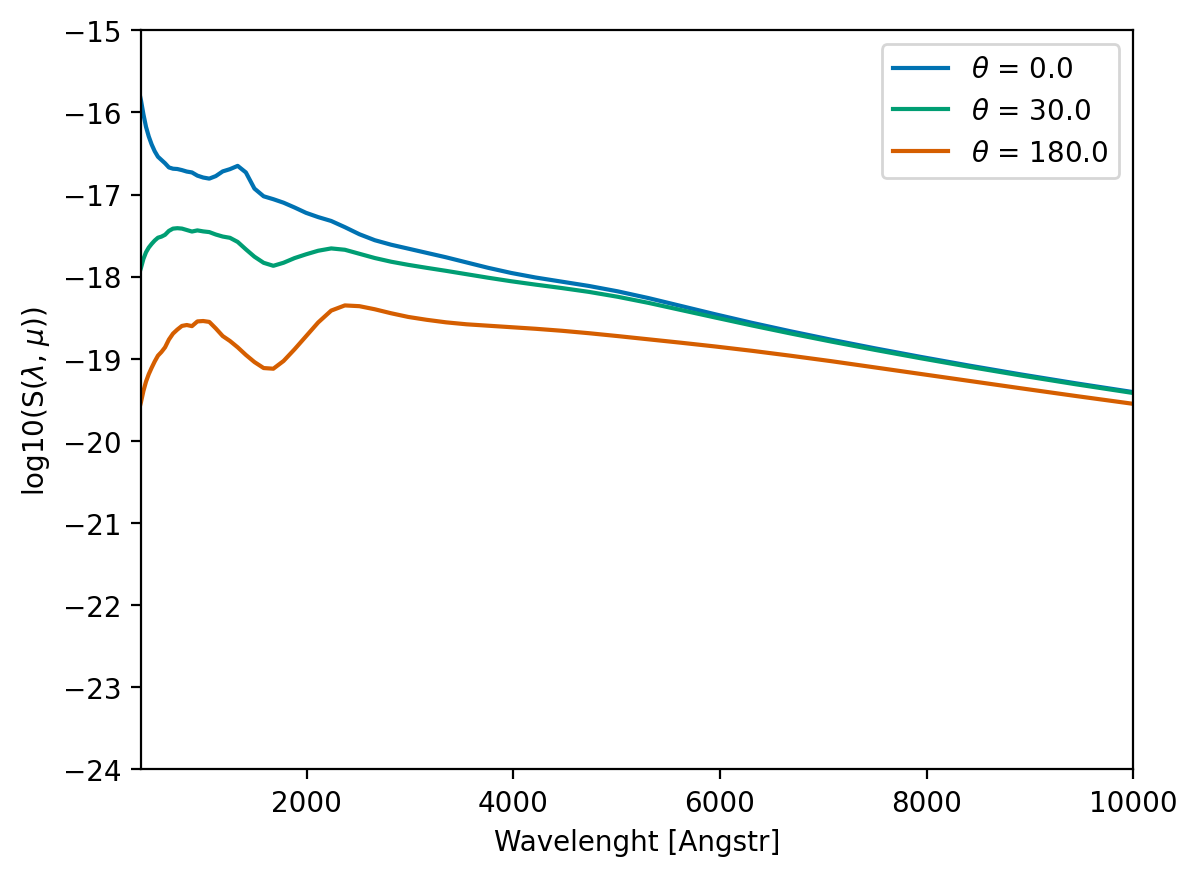

In [600]:
# dS(a, Qsc, phi, f)
# m = np.cos(0)
for m in [np.cos(0), np.cos(np.deg2rad(30)), np.cos(np.deg2rad(180))]:
  ds = []
  # iterate over the array of points to search for matching (wave, a) point
  for idy in range(0,len(waveg)):
    for idx in range(0,len(sizeg)):
        # if the first value of the current point matches wave and if the second value matches a
        # return the corresponding Qsc value
        if ((sizeg[idx] >= 0.01) & (sizeg[idx] <= 0.1)):
          ids = len(waveg) * idx + idy
          Qsc = Qcarb[ids]
          g = gcarb[ids]
          phi = Phi(m, g)
          f = carbon_distribution[idx]
          ds.append((Qsc * np.pi*(1e-4*sizeg[idx])**2 * phi * f))


  S = []
  ss = len(sizeg[(sizeg>= 0.01) & (sizeg <= 0.1)])
  for i in range(len(waveg)):
    S.append(integrate.simpson(ds[i*ss:ss*(i+1)], sizeg[(sizeg >= 0.01) & (sizeg <= 0.1)]))

  plt.plot(waveg*10000, np.log10(S), label = r"$\theta$ = %s"%(round(np.rad2deg(np.arccos(m)),1)))
  plt.xlim(4e2,1e4)
  plt.ylim(-24,-15)
  plt.xlabel("Wavelenght [Angstr]")
  plt.ylabel(r"log10(S($\lambda$, $\mu$))")
  plt.legend()
        # print(ds)

In [545]:
#  import BSpline

from scipy.interpolate import CubicSpline, interp2d, RegularGridInterpolator, NearestNDInterpolator

logwaveg = np.log10(1e-4 * waveg)
logsizeg = np.log10(1e-4 * sizeg)


stepx = 0.0025
stepy = 0.0125
X = np.arange(min(logwaveg), max(logwaveg)+ stepx, stepx)
Y = np.arange(min(logsizeg), max(logsizeg)+ stepy, stepy)

# X = np.linspace(min(logwaveg), max(logwaveg))
# Y = np.linspace(min(logsizeg), max(logsizeg))

Xi, Yi = np.meshgrid(X, Y)  # 2D grid for interpolation
points_interp = np.asarray([[Xi[idx2,idx1], Yi[idx2,idx1]] for idx1 in range(0,len(X)) for idx2 in range(0,len(Y))])


# combine wavelength and size into a meshgrid
xx, yy = np.meshgrid(logwaveg, logsizeg)
# create an array of points from the meshgrid
points = np.asarray([[xx[idx2,idx1], yy[idx2,idx1]] for idx1 in range(0,len(logwaveg)) for idx2 in range(0,len(logsizeg))])
# create an array of corresponding Qsc values
values = np.asarray([Qcarb[idx1+(len(logwaveg)*idx2)] for idx1 in range(0,len(logwaveg)) for idx2 in range(0,len(logsizeg))])

valuesg = np.asarray([gcarb[idx1+(len(logwaveg)*idx2)] for idx1 in range(0,len(logwaveg)) for idx2 in range(0,len(logsizeg))])



In [546]:
logwaveg.shape[0] * logsizeg.shape[0]

19521

In [547]:
# interp = LinearNDInterpolator(points, values, fill_value=0.00)
# interp = CubicSpline(points, values)
# interp = interp2d(X,Y,Qcarb, kind='cubic')
interp_q = NearestNDInterpolator(points, values)
Q_inter = interp_q(points_interp)

interp_g = NearestNDInterpolator(points, valuesg)
g_inter = interp_g(points_interp)

In [548]:
Y.shape, X.shape

((321,), (2401,))

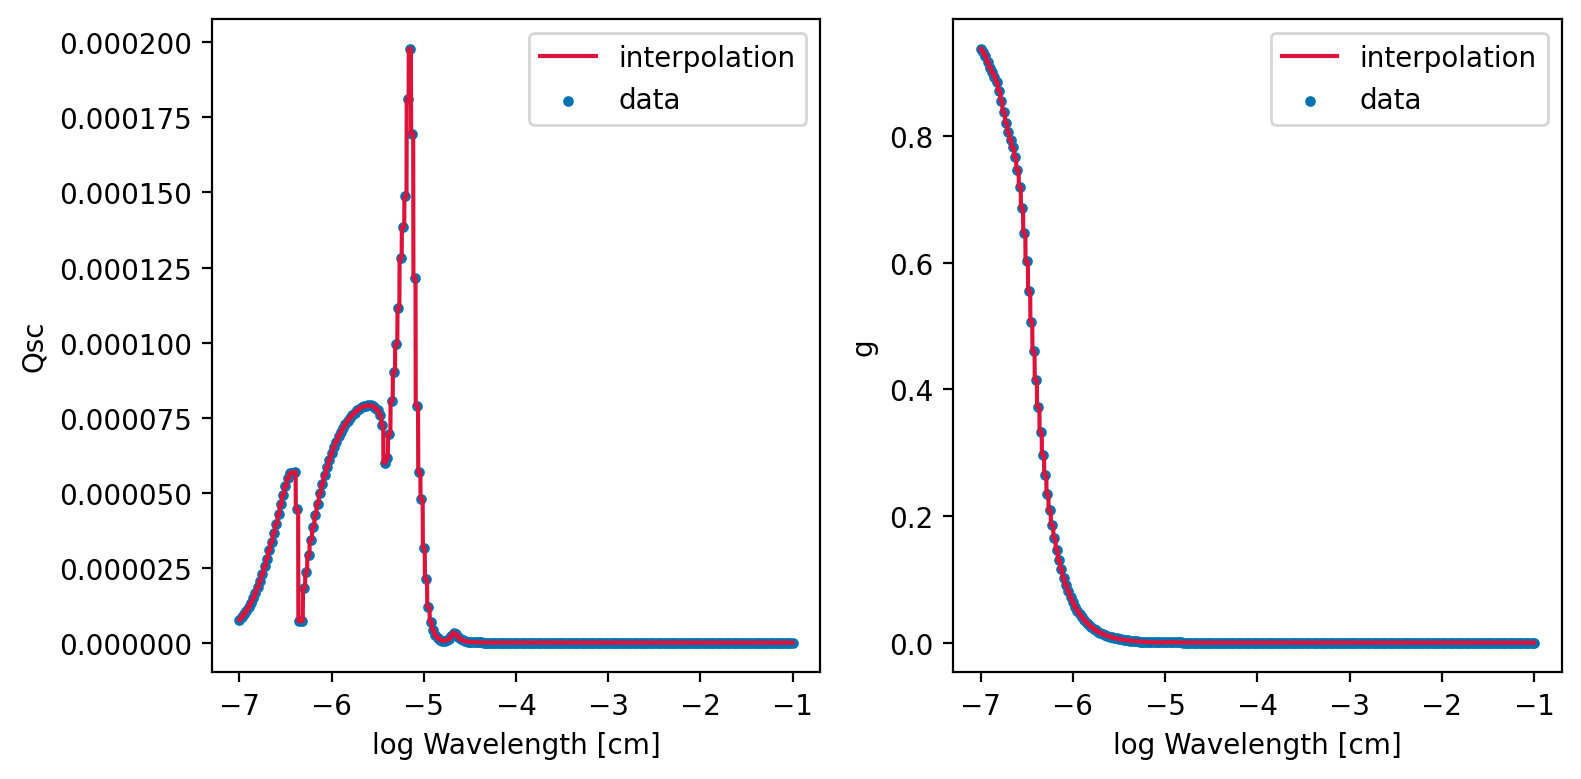

In [549]:
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.plot(X, Q_inter[::321], color = "crimson", label = "interpolation")
plt.scatter(logwaveg, values[::81], s = 8, label = "data")
plt.legend()
plt.xlabel(r"log Wavelength [cm]")
plt.ylabel(r"Qsc")

plt.subplot(122)
plt.plot(X, g_inter[::321], color = "crimson", label = "interpolation")
plt.scatter(logwaveg, valuesg[::81], s = 8, label = "data")
plt.legend()
plt.xlabel(r"log Wavelength [cm]")
plt.ylabel(r"g")

plt.tight_layout()
